In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rioxarray
import contextily as ctx
import numpy as np
from shapely.geometry import Point
import pysal.lib as ps
import urllib.request
import os
import xdem


In [2]:
ETH_region = gpd.read_file("Data/Shapefiles/ETH2021/eth_admbnda_adm1_csa_bofedb_2021.shp")
ETH_region.head()

,Shape_Leng,Shape_Area,ADM1_EN,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,1.010869,0.044369,Addis Ababa,ET14,None,None,None,Ethiopia,ET,2021-12-09,2021-12-14,NaT,"POLYGON ((38.78084 9.09042, 38.79131 9.07768, ..."
1,16.751971,7.879581,Afar,ET02,None,None,None,Ethiopia,ET,2021-12-09,2021-12-14,NaT,"POLYGON ((40.17299 14.49028, 40.22259 14.47863..."
2,25.894222,12.901454,Amhara,ET03,None,None,None,Ethiopia,ET,2021-12-09,2021-12-14,NaT,"POLYGON ((36.52608 13.58428, 36.53155 13.58167..."
3,15.641216,4.149305,Benishangul Gumz,ET06,None,None,None,Ethiopia,ET,2021-12-09,2021-12-14,NaT,"MULTIPOLYGON (((36.23862 8.96511, 36.22213 8.9..."
4,1.692570,0.086757,Dire Dawa,ET15,None,None,None,Ethiopia,ET,2021-12-09,2021-12-14,NaT,"POLYGON ((42.26265 9.6569, 42.25864 9.65158, 4..."


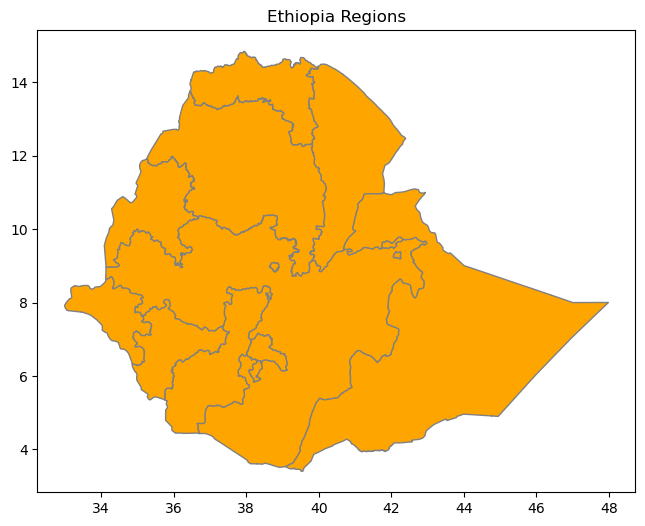

In [3]:
ETH_region.plot(figsize=(8, 6), edgecolor="grey", color="orange")
plt.title("Ethiopia Regions")
plt.show()

In [4]:
ETH_region.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

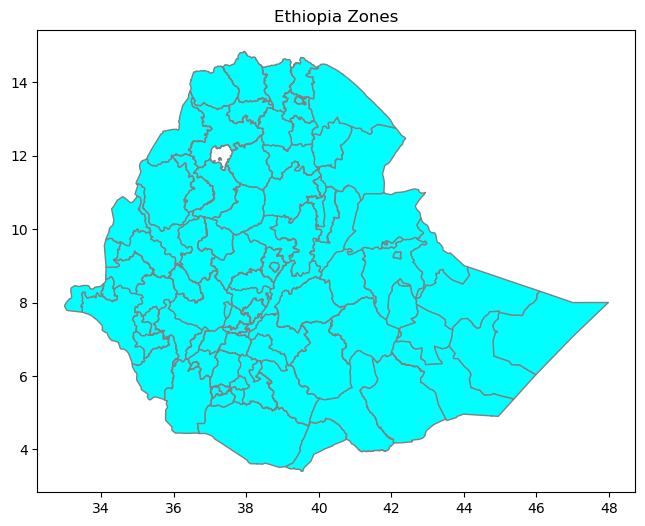

In [5]:
ETH_zone = gpd.read_file("Data/Shapefiles/ETH2021/eth_admbnda_adm2_csa_bofedb_2021.shp")
ETH_zone.plot(figsize=(8, 6), edgecolor="grey", color="cyan")
plt.title("Ethiopia Zones")
plt.show()

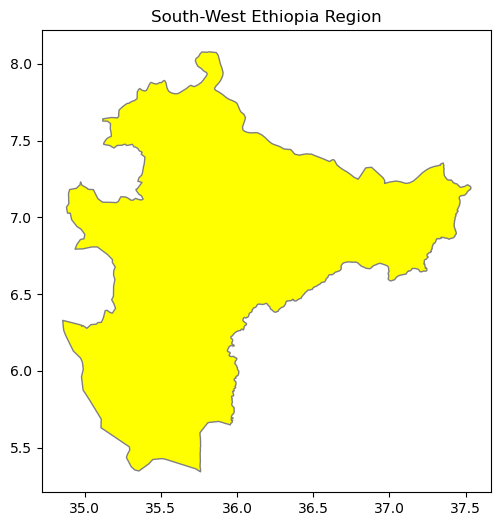

In [6]:
sweth = ETH_region[ETH_region["ADM1_PCODE"] == "ET11"]
sweth.plot(figsize=(8,6), edgecolor="grey", color="yellow")
plt.title("South-West Ethiopia Region")
plt.show()

In [7]:
mcp_data = pd.read_csv("Data/mCP2019.csv")
mcp_data

,Region,Zone,mcp,mean
0,Somali,Afder,0.00,8.17
1,Gambela,Agnewak,38.58,0.48
2,SNNP,Alle,16.28,1.72
3,SNNP,Amaro,24.98,1.69
4,Oromia,Arsi,39.33,3.10
...,...,...,...,...
87,Oromia,W_Wellega,56.98,1.01
88,Tigray,Western,42.87,0.48
89,SNNP,Wolayita,34.87,1.63
90,SNNP,Yem,24.98,1.69


In [8]:
ETH_zone["mcp"] = mcp_data.mcp
ETH_zone["mean_dist"] = mcp_data["mean"]
ETH_zone.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Shape_Leng  92 non-null     float64       
 1   Shape_Area  92 non-null     float64       
 2   ADM2_EN     92 non-null     object        
 3   ADM2_PCODE  92 non-null     object        
 4   ADM2_REF    0 non-null      object        
 5   ADM2ALT1EN  0 non-null      object        
 6   ADM2ALT2EN  0 non-null      object        
 7   ADM1_EN     92 non-null     object        
 8   ADM1_PCODE  92 non-null     object        
 9   ADM0_EN     92 non-null     object        
 10  ADM0_PCODE  92 non-null     object        
 11  date        92 non-null     datetime64[ms]
 12  validOn     92 non-null     datetime64[ms]
 13  validTo     0 non-null      datetime64[ms]
 14  geometry    92 non-null     geometry      
 15  mcp         92 non-null     float64       
 16  mean_dist   92 non-n

In [9]:
ETH_zone_mcp = ETH_zone[["ADM1_EN", "ADM2_EN", "ADM2_PCODE", "geometry", "mcp", "mean_dist"]]
ETH_zone_mcp.head()

,ADM1_EN,ADM2_EN,ADM2_PCODE,geometry,mcp,mean_dist
0,Somali,Afder,ET0508,"POLYGON ((42.02878 6.61478, 42.03432 6.61348, ...",0.00,8.17
1,Gambela,Agnewak,ET1202,"POLYGON ((34.82643 8.26194, 34.85509 8.25065, ...",38.58,0.48
2,SNNP,Alle,ET0712,"POLYGON ((37.12605 5.72774, 37.12655 5.72627, ...",16.28,1.72
3,SNNP,Amaro,ET0721,"POLYGON ((37.85677 5.9987, 37.86554 5.98663, 3...",24.98,1.69
4,Oromia,Arsi,ET0408,"POLYGON ((39.92013 8.70959, 39.92602 8.70937, ...",39.33,3.10


Raster data management

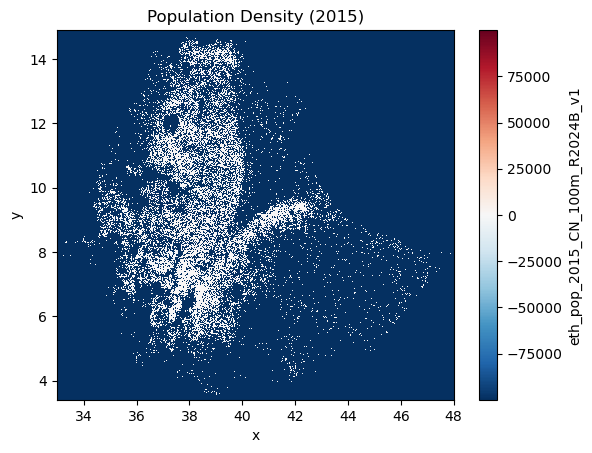

In [11]:
access = rioxarray.open_rasterio("Data/Shapefiles/raster/eth_pop_2015.tif")
subset = access.isel(x=slice(None, None, 20), y=slice(None, None, 20))
subset.plot()
plt.title("Population Density (2015)")
plt.show()

In [8]:
access.rio.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [9]:
r2 = access.rio.reproject("EPSG:32636")
r2.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 36N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",33],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32636"]]')

<open DatasetReader name='RGB.byte.tif' mode='r'>


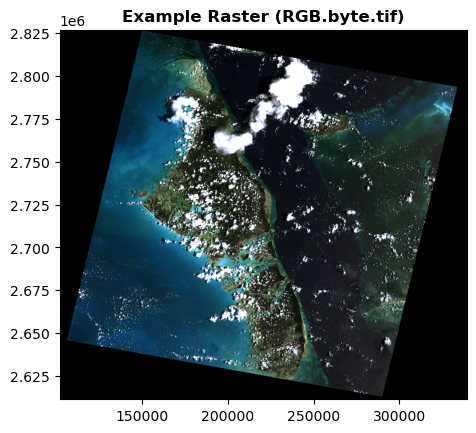

<Axes: title={'center': 'Example Raster (RGB.byte.tif)'}>

In [ ]:
# raster
# URL of the sample raster from Rasterio’s GitHub repo
url = "https://github.com/mapbox/rasterio/raw/main/tests/data/RGB.byte.tif"
fp = "RGB.byte.tif"

# Download only if it’s not already present
if not os.path.exists(fp):
    urllib.request.urlretrieve(url, fp)

# Open the raster
r = rasterio.open(fp)
print(r)

# Plot it
show(r, title="Example Raster (RGB.byte.tif)")


In [2]:
dem = xdem.DEM(xdem.examples.get_path("longyearbyen_ref_dem"))

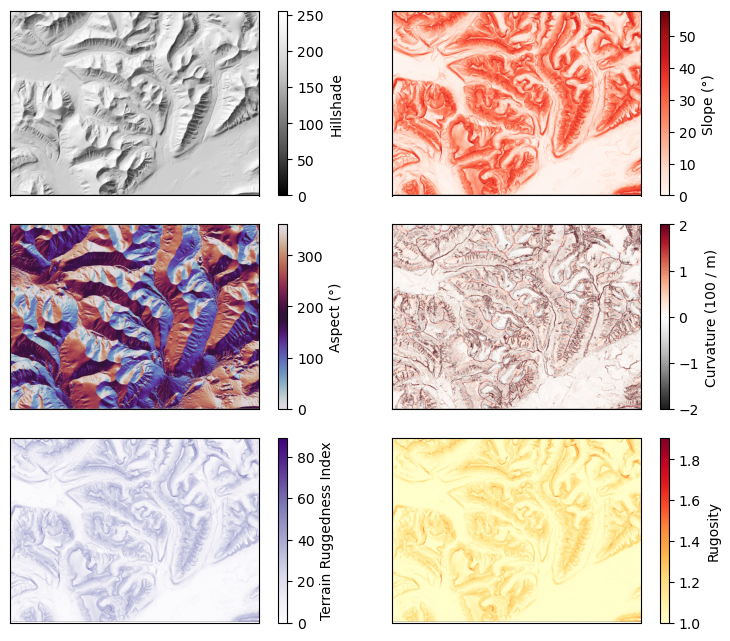

In [3]:
attributes = xdem.terrain.get_terrain_attribute(
    dem.data,
    resolution=dem.res,
    attribute=["hillshade", "slope", "aspect", "curvature", "terrain_ruggedness_index", "rugosity"],
)

plt.figure(figsize=(8, 6.5))

plt_extent = [dem.bounds.left, dem.bounds.right, dem.bounds.bottom, dem.bounds.top]

cmaps = ["Greys_r", "Reds", "twilight", "RdGy_r", "Purples", "YlOrRd"]
labels = ["Hillshade", "Slope (°)", "Aspect (°)", "Curvature (100 / m)", "Terrain Ruggedness Index", "Rugosity"]
vlims = [(None, None) for i in range(6)]
vlims[3] = [-2, 2]

for i in range(6):
    plt.subplot(3, 2, i + 1)
    plt.imshow(attributes[i].squeeze(), cmap=cmaps[i], extent=plt_extent, vmin=vlims[i][0], vmax=vlims[i][1])
    cbar = plt.colorbar()
    cbar.set_label(labels[i])
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

Creating spatial data

In [7]:
df = pd.DataFrame({
    "x": [1, 2, 3, 4, 5],
    "y": [0.5, 1.5, 3.0, 4.6, 6.4]
})

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["x"], df["y"]))
gdf

,x,y,geometry
0,1,0.5,POINT (1 0.5)
1,2,1.5,POINT (2 1.5)
2,3,3.0,POINT (3 3)
3,4,4.6,POINT (4 4.6)
4,5,6.4,POINT (5 6.4)


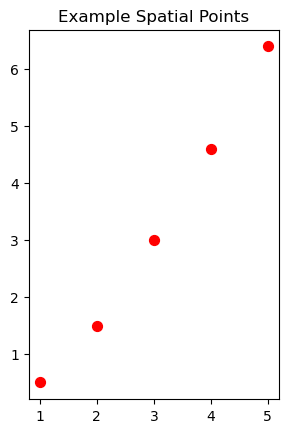

In [8]:
gdf.plot(color="red", markersize=50)
plt.title("Example Spatial Points")
plt.show()

In [9]:
gdf_latlon = gdf.set_crs("EPSG:32632").to_crs("EPSG:4326")
gdf_latlon

,x,y,geometry
0,1,0.5,POINT (4.51127 4.50969e-6)
1,2,1.5,POINT (4.51127 1.35291e-5)
2,3,3.0,POINT (4.51128 2.70581e-5)
3,4,4.6,POINT (4.51129 4.14891e-5)
4,5,6.4,POINT (4.5113 5.7724e-5)


In [ ]:
####################################
# Part 2: Data Visualization
####################################

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm

# Load Africa map
africa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = africa[africa['continent'] == 'Africa']

# Load nutrition data and merge
d = pd.read_csv("Data/Africa_Nutrition.csv")
africa["underweight"] = d["Under.weight"]
africa["normal"] = d["Normal.Weight"]
africa["overweight"] = d["Over.weight"]
africa["obese"] = d["Obese"]

# Map obesity levels
fig, ax = plt.subplots(figsize=(10, 8))
africa.plot(column="obese", cmap="viridis", legend=True, ax=ax)
ax.set_title("Obesity by Country in Africa", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.savefig("Obese.png", dpi=300)
plt.show()

####################################
# Part 3: Spatial Weighting Matrix
####################################

# Example: Construct Queen contiguity spatial weights for ETH_zone
ETH_zone = ETH_zone.to_crs("EPSG:4326")
w = ps.weights.Queen.from_dataframe(ETH_zone)
w.transform = "R"
print(w.sparse)  # adjacency matrix

####################################
# Part 4: Spatial Autoregressive Data Modeling
####################################

# Example: Spatial lag model placeholder (using spreg)
from pysal.model import spreg

# Suppose 'mcp' is dependent and 'mean_dist' is independent variable
y = ETH_zone["mcp"].values.reshape(-1, 1)
X = ETH_zone[["mean_dist"]].values

# Spatial Lag Model
lag_model = spreg.ML_Lag(y, X, w=w, name_y="mcp", name_x=["mean_dist"])
print(lag_model.summary)
